In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from denoising.denoise import Denoising
from denoising.atlas import Atlas
from denoising.dataset import Dataset
from denoising.helpers import *
from seaborn import heatmap
from pathlib import Path

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

### aalf reho

In [3]:
import fnmatch
path = '/home/tm/OpenCloseProject/xcp/xcp_d'
patt = 'sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_alff.nii.gz'
subs = [f'sub-{i:03d}' for i in range(1, 85)]
for sub in subs:
    curpath = f'{path}/{sub}/'
    alff = f'{sub}'


In [8]:
import os, fnmatch
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result



['/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_reho.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_reho.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_alff.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-denoised_bold.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_alff.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-denoised_bold.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/anat/sub-001_space-MNI152NLin2009cAsym_dseg.nii.gz',
 '/home/tm/OpenCloseProject/xcp/xcp_d/sub-001/anat/sub-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']

In [11]:
paths_reho = []
paths_alff = []
for sub in subs:
    curpath = f'{path}/{sub}/'
    paths_reho.extend(find('*reho.nii.gz', curpath))
    paths_alff.extend(find('*alff.nii.gz', curpath))


In [12]:
os.mkdir('/home/tm/rho_alff')
os.mkdir('/home/tm/rho_alff/open')
os.mkdir('/home/tm/rho_alff/close')
os.mkdir('/home/tm/rho_alff/open/reho')
os.mkdir('/home/tm/rho_alff/close/reho')
os.mkdir('/home/tm/rho_alff/open/alff')
os.mkdir('/home/tm/rho_alff/close/alff')

In [14]:
import shutil 
for p in paths_alff:
    if 'run-1' in p:
        shutil.copy(p, '/home/tm/rho_alff/close/alff')

    elif 'run-2' in p:
        shutil.copy(p, '/home/tm/rho_alff/open/alff')

In [15]:
import shutil 
for p in paths_reho:
    if 'run-1' in p:
        shutil.copy(p, '/home/tm/rho_alff/close/reho')

    elif 'run-2' in p:
        shutil.copy(p, '/home/tm/rho_alff/open/reho')

## Denoising of fMRIprep output



### Create Dataset instance



In [3]:
from pathlib import Path

import bids
import pandas as pd


class Dataset:
    """
    Class to handle fmriprep output

    Attributes
    ----------
    bids_layout
        Returns dataset layout
    sub_labels
        Returns a list of subject labels
    
    Methods
    -------
    get_func_files(sub)
        Returns list of functional files paths

    """

    def __init__(self, derivatives_path: str, TR: float,
                 sessions: int, runs: int, task: str):
        """ 
        Parameters
        ----------
        derivatives_path: str
            Path to derivatives directory
        runs: int
            Number of runs in one folder
        task: str
            Task name
        """

        self.derivatives = Path(derivatives_path).as_posix()
        self.runs = runs
        self.sessions = sessions
        self.task = task
        self.t_r = TR
        self.bids_layout = bids.BIDSLayout(
            self.derivatives, validate=False, config=['bids', 'derivatives'])
        self.sub_labels = self.bids_layout.get_subjects()

    def get_confounds_one_subject(self, sub=None):
        """
        Get confounds dataframe

        Parameters
        ----------
        sub: str
            Subject label
        
        Returns
        -------
        list of pd.DataFrame
            List with dataframes for each run for one subject
        """
        conf_paths = self.bids_layout.get(subject=sub,
                                          extension='tsv',
                                          return_type='file')
        #print(len(conf_paths))
        return [pd.read_csv(conf_paths[i], sep='\t') for i in range(len(conf_paths))]

    def get_func_files(self, sub=None):
        """
        Get functional files' paths

        Parameters
        ----------
        sub: list of str, optional
            Subject labels to get files for. If None, all subjects are returned
        
        Returns
        -------
        list of str
        """

        if sub is None:
            sub = self.sub_labels
        return self.bids_layout.get(subject=sub,
                                    datatype='func',
                                    task=self.task,
                                    desc='preproc',
                                    space='MNI152NLin2009cAsym',
                                    extension='nii.gz',
                                    return_type='file')
    
    def get_mask_files(self, sub=None):
        """
        Get functional files' paths

        Parameters
        ----------
        sub: list of str, optional
            Subject labels to get files for. If None, all subjects are returned
        
        Returns
        -------
        list of str
        """

        if sub is None:
            sub = self.sub_labels
        return self.bids_layout.get(subject=sub,
                                    datatype='func',
                                    task=self.task,
                                    desc='brain',
                                    space='MNI152NLin2009cAsym',
                                    extension='nii.gz',
                                    return_type='file')

In [3]:
# paste derivatives path
derivatives_path = '/data/Projects/TestRetest_NYU/bids/derivatives' #'/arch/OpenCloseProject/derivatives/'#'/data/Projects/TestRetest_NYU/bids/derivatives' '/arch/OpenCloseBeijin/INDI_Lite_NIFTI/derivatives/'
#
# enter number of runs
runs = 1
sessions = 3

# enter task name
task = 'rest'
tr = 2.5


data = Dataset(derivatives_path=derivatives_path, 
               sessions=sessions,
               TR=tr,
               runs=runs,
               task=task)

In [4]:
sub = data.sub_labels[0]

In [76]:
conf = data.get_confounds_one_subject(sub=data.sub_labels[0])

In [6]:
data.get_mask_files(sub)

['/data/Projects/TestRetest_NYU/bids/derivatives/sub-05676/ses-1/func/sub-05676_ses-1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/data/Projects/TestRetest_NYU/bids/derivatives/sub-05676/ses-2/func/sub-05676_ses-2_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/data/Projects/TestRetest_NYU/bids/derivatives/sub-05676/ses-3/func/sub-05676_ses-3_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']

In [78]:
def mean_fd(sub, run):
    return np.mean(data.get_confounds_one_subject(sub)[run-1]['framewise_displacement'][1:])

In [ ]:
import pandas as pd

def reorder_matrix(matr):
    """
    Reorder FC matrix in Left-Right order
    
    Parameters
    ----------
    matr: np.array
        Matrix to reorder
    atlas_name: str
        One of ['HCPex', 'Schaefer200']

    Returns
    -------
    np.array
        Reordered matrix (wow!)
    """

    df = pd.read_excel('../atlas/HCPex_sorted.xlsx',
                            ).drop([401, 365, 398], axis=0).reset_index()
    map = dict(zip(df.index, df.HCPex_ID.values))

    if isinstance(matr, np.ndarray) and len(matr.shape) == 3:
        sort_0 = np.zeros_like(matr)
        for i in range(len(matr)):
            temp = matr[i][map[i]]
            sort_0[i] = temp.T[map[i]]
    else:
        sort_0 = matr[map[i]]
        sort_0 = sort_0.T[map[i]]

    return sort_0

### йсас


In [22]:
len(data.get_confounds_one_subject(sub))#[1-1]['framewise_displacement'][1:])

3

In [6]:
sub = data.sub_labels[0]

In [34]:
class QCFC:
    def __init__(self, data):
        self.data = data

    def _mean_fd_one(self, sub, run):
        return np.mean(
            self.data.get_confounds_one_subject(sub)[run-1]['framewise_displacement'][1:]) # FIX
        
    def mean_fd_vec(self, run):
        vec = np.zeros(len(self.data.sub_labels))
        failed = []
        for en, sub in enumerate(self.data.sub_labels):
            try:
                vec[en] = self._mean_fd_one(sub, run)
            except IndexError:
                vec[en] = -1
                failed.append(sub)
                continue


    def qc_fc(self, fc, run):
        qc_mat = np.zeros((fc.shape[1], fc.shape[2]))
        for i in range(fc.shape[1]):
            for t in range(fc.shape[2]):
                qc_mat[i, t] = np.corrcoef(fc[:, i, t], self.mean_fd_vec(run))#[0, 1]
        return qc_mat

In [35]:
qcfc = QCFC(data)

In [36]:
qcfc.qc_fc(trt_fc, 1)

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarning: invalid value encountered in divide
  return c / c
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarning: invalid value encountered in divide
  return c / c
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarning: invalid value encountered in divide
  return c / c
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarning: invalid value encountered in divide
  return c / c
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarning: invalid value encountered in divide
  return c / c
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2895: RuntimeWarn

KeyboardInterrupt: 

In [33]:
trt_fc.shape

(22, 200, 200)

In [30]:
mean_fd_vec

array([[0.06532998, 0.08344101, 0.12127805, 0.0838224 , 0.11088483,
        0.21319336, 0.22606816, 0.24830935, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.08814395, 0.08707372, 0.10488268, 0.11534507, 0.07440245,
        0.20360802, 0.26954697, 0.18610445, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [29]:
mean_fd_vec = np.zeros((2, len(data.sub_labels)))
for en, sub in enumerate(data.sub_labels):
    mean_fd_vec[0, en] = mean_fd(sub, 1)
    mean_fd_vec[1, en] = mean_fd(sub, 2)

IndexError: list index out of range

In [28]:
import pingouin as pg
print(pg.ttest(x=mean_fd_vec[0], y=mean_fd_vec[1], alternative='two-sided', paired=True).round(2))

           T  dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  1.73   83   two-sided   0.09  [-0.0, 0.04]     0.22  0.499    0.5


In [8]:
def qc_fc(fc, run):
    qc_mat = np.zeros((fc.shape[1], fc.shape[2]))
    for i in range(fc.shape[1]):
        for t in range(fc.shape[2]):
            qc_mat[i, t] = np.corrcoef(fc[:, i, t], mean_fd_vec[run-1])[0, 1]
    return qc_mat


In [14]:
qc_cl = qc_fc(fc_cl, 1)

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

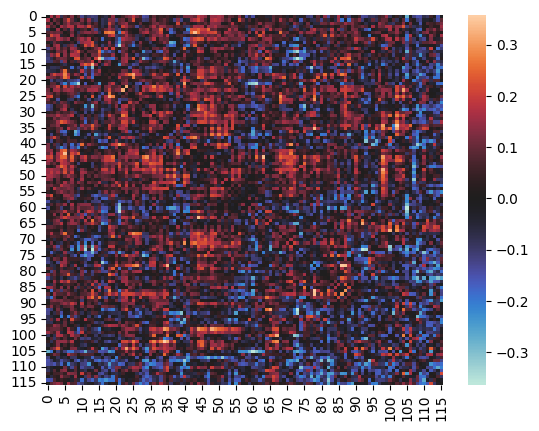

In [32]:
from seaborn import heatmap
heatmap(qc_cl, center=0)

In [16]:
np.fill_diagonal(qc_cl, 0)
np.mean(qc_cl)

0.015205037092054627

<Axes: >

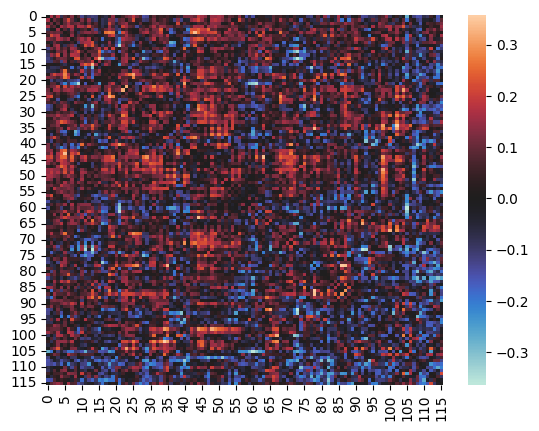

In [31]:
from seaborn import heatmap
heatmap(qc_cl, center=0)

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

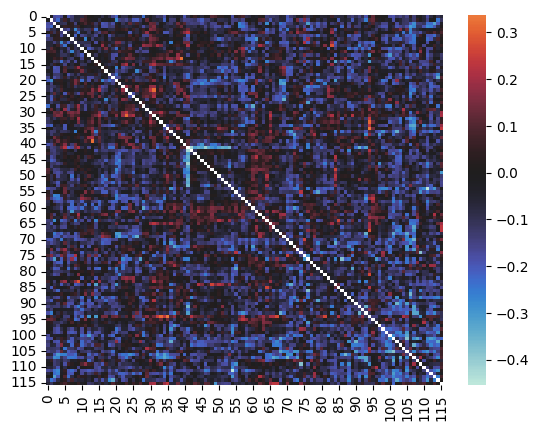

In [17]:
qc_op = qc_fc(fc_op, 2)
heatmap(qc_op, center=0)

In [18]:
np.fill_diagonal(qc_op, 0)
np.mean(qc_op)

-0.05764959965962499

In [30]:
import pingouin as pg
print(pg.ttest(x=qc_op.flatten(), y=qc_cl.flatten(), alternative='two-sided', paired=True).round(2))

            T    dof alternative  p-val           CI95%  cohen-d BF10  power
T-test -58.74  13455   two-sided    0.0  [-0.08, -0.07]      0.7  inf    1.0


/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


In [70]:
np.fill_diagonal(qc_op, 0)
np.mean(qc_op)

-0.07653900300954104

In [71]:
np.fill_diagonal(qc_cl, 0)
np.mean(qc_cl)

-0.004374679559362132

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

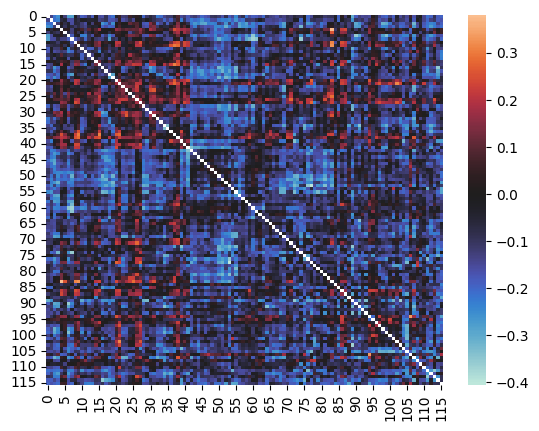

In [65]:
qc_op = qc_fc(fc_op, 2)
heatmap(qc_op, center=0)

In [4]:
' '.join(data.sub_labels)

'001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084'

In [53]:
data.get_func_files('001')

['/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

In [54]:
data.get_mask_files('001')

['/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']

In [ ]:
to_resample = [ffiles[1], mfiles[1]]
ref = ffiles[0]

new_img = resample_to_img(to_resample, ref, 'nearest')

In [56]:
from skimage.transform import resize
import nibabel as nib

ref = nib.load(
    '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
img = nib.load(
    '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
mask = nib.load(
    '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')


In [18]:
ref_data = ref.get_fdata()
mask_data = mask.get_fdata()
ref_data.shape, mask_data.shape

((120, 142, 50, 120), (120, 142, 50, 120))

In [ ]:
ref_size = ref_data.shape[:3] 
# ref image data is a 4-D array (length, length, length, time). Takes the first brain volume size.
output = resize(ref_data, ref_size, order=1, mode='reflect') # order=1 
#(Bi-linear) is the default value and it seems that with 3D image, 
#Bi-linear is equivalent to 'trilinear' of SPM's imcalc function ?
output_ref_mask = nib.Nifti1Image(output, ref.affine, mask.header) # 
#Here some test was done by using also 
output_ref_ref = nib.Nifti1Image(output, ref.affine, ref.header) #etc.
#nib.save(output_ref_mask, 
#'/home/tm/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
#nib.save(output_ref_ref, 
#'/home/tm/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

In [12]:
ref.affine

array([[   1.625    ,    0.       ,    0.       ,  -96.5      ],
       [   0.       ,    1.625    ,    0.       , -132.5      ],
       [   0.       ,    0.       ,    3.9920001,  -78.5      ],
       [   0.       ,    0.       ,    0.       ,    1.       ]])

In [13]:
mask.affine

array([[   1.625     ,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.625     ,    0.        , -132.5       ],
       [   0.        ,    0.        ,    3.99000001,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [5]:
ref = nib.load('/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
ref.affine

array([[   1.625     ,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.625     ,    0.        , -132.5       ],
       [   0.        ,    0.        ,    3.99000001,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [10]:
nib.load(
    '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz').affine

array([[   1.625     ,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.625     ,    0.        , -132.5       ],
       [   0.        ,    0.        ,    3.99000001,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [44]:
from nibabel import processing
new_mask = processing.resample_from_to(ref, mask)

In [60]:
from nilearn.image import resample_to_img
new_img = resample_to_img(img, ref, 'nearest')
new_mask = resample_to_img(mask, ref, 'nearest')

In [27]:
new_mask2.affine

array([[   1.625     ,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.625     ,    0.        , -132.5       ],
       [   0.        ,    0.        ,    3.99000001,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [37]:
np.max(ref_data), np.min(ref_data)

(3584.72021484375, 0.0)

In [45]:
np.max(new_mask2.get_fdata()), np.min(new_mask2.get_fdata())

(3582.93896484375, -5.817459583282471)

In [50]:
np.sum(np.allclose(ref_data, new_mask2.get_fdata()))

1

In [39]:
np.max(new_mask.get_fdata())

3584.72021484375

In [19]:
new_mask.shape

(120, 142, 50, 120)

In [16]:
new_mask.affine 

array([[   1.625     ,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.625     ,    0.        , -132.5       ],
       [   0.        ,    0.        ,    3.99000001,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [32]:
nib.save(new_mask, '/home/tm/test_run1_to_run2_try3.nii.gz')

In [128]:
data.sub_labels[0]

'1024011'

In [12]:
data.sub_labels[8:]

['33259',
 '34482',
 '36678',
 '38579',
 '39529',
 '45463',
 '47000',
 '49401',
 '52738',
 '55441',
 '58949',
 '60624',
 '76987',
 '84403',
 '86146',
 '90179',
 '94293']

In [9]:
data.get_mask_files('27641')

['/data/Projects/TestRetest_NYU/bids/derivatives/sub-27641/ses-1/func/sub-27641_ses-1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/data/Projects/TestRetest_NYU/bids/derivatives/sub-27641/ses-2/func/sub-27641_ses-2_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/data/Projects/TestRetest_NYU/bids/derivatives/sub-27641/ses-3/func/sub-27641_ses-3_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']

### Create Atlas instance

3 atlases are implemented:
1. `HCPex`, 426 ROI 
2. `Schaefer200`, 200 ROI
3. `AAL`, 116 ROI

In [67]:
from pathlib import Path
import os
import pandas as pd
from nilearn.maskers import NiftiLabelsMasker
from nilearn.datasets import fetch_atlas_aal, fetch_atlas_schaefer_2018
import requests
from urllib.parse import urlencode


class Atlas:
    """
    Class to handle atlas file

    Attributes
    ----------
    atlas_name
        Returns atlas name
    atlas_path
        Loads atlas and returns path to atlas file
    atlas_labels
        Returns ROI labels
    masker
        Returns time series extractor instance
    """

    def __init__(self, atlas_name, mean_mask=None):
        """
        Parameters
        ----------
        atlas_name: str
            One of ['HCPex', 'Schaefer200', 'AAL', 'Brainnetome']
        
        Raise
        -----
        NotImplementedError
            If unknown atlas name is provided
        """

        if atlas_name not in ['HCPex', 'Schaefer200', 'AAL', 'Brainnetome']:
            raise NotImplementedError(
                'Available atlases: HCPex, Schaefer200, AAL, Brainnetome')

        self.atlas_name = atlas_name
        self.atlas_labels_path = Path('../atlas/')
        self.mask = mean_mask

    @property
    def atlas_path(self):
        if self.atlas_name in ['HCPex', 'Brainnetome']:
            return self._load_atlas()

        elif self.atlas_name == 'AAL':
            self.atlas = fetch_atlas_aal(data_dir=self.atlas_labels_path)
            return self.atlas['maps']

        elif self.atlas_name == 'Schaefer200':
            self.atlas = fetch_atlas_schaefer_2018(
                n_rois=200, data_dir=self.atlas_labels_path)
            return self.atlas['maps']

    def _load_atlas(self):
        """
        Loads atlas file from Yandex Disk

        Returns
        -------
        path to loaded file
        """
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

        if self.atlas_name == 'HCPex':
            public_key = 'https://disk.yandex.ru/d/AHkSrMBH8wYGHA'
            fname = os.path.join('../atlas', 'HCPex.nii.gz')

        elif self.atlas_name == 'Brainnetome':
            public_key = 'https://disk.yandex.ru/d/Fo2j_VPpS7xWiA'
            fname = os.path.join('../atlas', 'BN_Atlas_246_2mm.nii.gz')

        if os.path.exists(fname):
            return fname

        # Получаем загрузочную ссылку
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url)
        download_url = response.json()['href']

        # Загружаем файл и сохраняем его
        download_response = requests.get(download_url)
        with open(fname, 'wb') as f:
            f.write(download_response.content)

        return os.path.abspath(fname)

    @property
    def atlas_labels(self):

        if self.atlas_name == 'HCPex':
            roi = pd.read_excel(os.path.join(self.atlas_labels_path, 'HCPex_sorted.xlsx'),
                                index_col='HCPex_ID')
            #roi_labels = roi.index.values
            #roi_labels = roi.sort_values(by='HCPex_ID').index.values
            #roi_labels = roi.drop([401, 365, 398], axis=0).index.values
            #roi_labels = roi.drop([396, 365, 401, 372, 405], axis=0).index.values
            roi_labels = roi.sort_index()
            #roi_labels = roi.drop([401, 372, 405], axis=0).Short_label.values

        elif self.atlas_name == 'Schaefer200':
            roi_labels = self.atlas['labels']

        elif self.atlas_name == 'AAL':
            roi_labels = self.atlas['labels']

        elif self.atlas_name == 'Brainnetome':
            roi = pd.read_csv(os.path.join(self.atlas_labels_path, 'BN_Atlas_246_LUT.txt'),
                              index_col=0, sep=' ')
            roi_labels = roi.Unknown.values

        return roi_labels

    @property
    def masker(self):
        mask = NiftiLabelsMasker(labels_img=self.atlas_path,
                                 labels=self.atlas_labels,
                                 mask_img=self.mask,
                                 memory="nilearn_cache",
                                 verbose=-1,
                                 standardize=False, #'zscore_sample',
                                 detrend=True,
                                 resampling_target='data', #'labels'
                                 n_jobs=-1 # fix 
                                 )
        return mask


In [7]:
# enter atlas name
atlas_name = 'HCPex'
mean_mask = '/home/tm/projects/OpenCloseProject/notebooks/mean_mask_trt_03.nii.gz'
atlas = Atlas(atlas_name=atlas_name, mean_mask=mean_mask)

## Denoising

### 5 strategies:

1. 24 parameters: 6 motion parameters, 6 temporal derivatives, 6 quadratic terms, and 6 quadratic expansions of the derivatives of motion estimates for a total 24 regressors;

2. aCompCor + 12P: 10 principal components calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

3. aCompCor50 + 12 parameters: principal components, which explain 50% of variance, calculated using a white matter and CSF combined anatomical mask, in addition to motion estimates and their temporal derivatives;

4. aCompCor + 24P: 10 principal components and 24 parameters;

5. aCompCor50 + 24P: same, principal components, which explain 50% of variance are used.

To each strategy global signal regressors (GSR) can be added (4 regressors: the global signal, its derivative, its square, and the derivative of its square). GSR is not used by default. 

By default, we add discrete cosines transformation basis regressors to handle low-frequency signal drifts. Instead, a bandpass filter (0.008 Hz and 0.09 Hz) can be used.

#### hide

In [8]:
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

In [9]:
atlas.atlas_path

'../atlas/HCPex.nii.gz'

In [10]:
atlas_img = nib.load(atlas.atlas_path)

In [11]:
masker_labels = atlas.atlas_labels

In [12]:
mask_path = '/home/tm/projects/OpenCloseProject/notebooks/mean_mask_trt_03.nii.gz'
mask = nib.load(mask_path)
mask.shape

(53, 65, 56)

In [55]:
mask = new_mask

In [13]:
# все что не ноль то один
atlas_img_bin = nib.Nifti1Image(
            (atlas_img.get_fdata() > 0).astype(np.uint8),
            atlas_img.affine,
            atlas_img.header,
            )


sum_masker_masked = NiftiLabelsMasker(
                        labels_img=atlas_img,
                        labels=masker_labels,
                        background_label=0,
                        mask_img=mask,
                        smoothing_fwhm=None,
                        standardize=False,
                        strategy="sum",
                        resampling_target='data',  
                        )

# no mask image here !!
sum_masker_unmasked = NiftiLabelsMasker(
                        labels_img=atlas_img,
                        labels=masker_labels,
                        background_label=0,
                        smoothing_fwhm=None,
                        standardize=False,
                        strategy="sum", # sum to see number of 
                        resampling_target='data',
                        )


# вместо мозга передаем бинаризованый атлас, 
# и считаем сколько вокселей попадает в маску (суммируем количество вокселей в рои)
n_voxels_in_masked_parcels = sum_masker_masked.fit_transform(atlas_img_bin)
# считаем сколько всего вокселей в рои в атласе
n_voxels_in_parcels = sum_masker_unmasked.fit_transform(atlas_img_bin)
# процент вокселей в маске
parcel_coverage = np.squeeze(n_voxels_in_masked_parcels / n_voxels_in_parcels)

In [18]:
np.save('./parcel_coverage_china_03.npy', parcel_coverage)

In [14]:
n_nodes = len(atlas.atlas_labels)
min_coverage = 0.5
coverage_thresholded = parcel_coverage < min_coverage
n_found_nodes = coverage_thresholded.size
n_bad_nodes = np.sum(parcel_coverage == 0)
n_poor_parcels = np.sum(
    np.logical_and(parcel_coverage > 0, parcel_coverage < min_coverage)
)
n_partial_parcels = np.sum(
    np.logical_and(parcel_coverage >= min_coverage, parcel_coverage < 1)
)

In [15]:
n_bad_nodes

0

In [16]:
n_poor_parcels

16

In [17]:
n_partial_parcels

201

In [74]:
np.array(atlas.atlas_labels)[parcel_coverage > min_coverage].shape

(410, 16)

In [18]:
np.array(atlas.atlas_labels)[parcel_coverage == 1].shape

(209, 16)

In [42]:
l = list(atlas.atlas_labels).insert(0, 'None')

['/arch/OpenCloseBeijin/INDI_Lite_NIFTI/derivatives/sub-1024011/func/sub-1024011_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/arch/OpenCloseBeijin/INDI_Lite_NIFTI/derivatives/sub-1024011/func/sub-1024011_task-rest_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 '/arch/OpenCloseBeijin/INDI_Lite_NIFTI/derivatives/sub-1024011/func/sub-1024011_task-rest_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz']

In [40]:


mask = data.get_mask_files(sub=data.sub_labels[0])[0]
img_pth = data.get_func_files(sub=data.sub_labels[0])[0]

mskr = NiftiMasker(mask)

img = nib.load(img_pth)
img.shape

mskr.fit(img_pth)

NiftiMasker(mask_img='/data/Projects/TestRetest_NYU/bids/derivatives/sub-05676/ses-1/func/sub-05676_ses-1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')

In [41]:
img.shape

(53, 65, 56, 197)

In [42]:
def new_mask_calc(img_pth, mask_pth, gs, thr):
    mskr = NiftiMasker(mask_pth)
    mskr.fit(img_pth)
    tr = mskr.transform(img_pth)
    a = np.array([tr[i] > (gs[i] * thr) for i in range(120)])
    t = tr * a
    return t

In [45]:
masks = []
thr = 0.6

for sub in data.sub_labels:
    try:
        func_files = data.get_func_files(sub)[0]
        mask_files = data.get_mask_files(sub)[0]
        gs = data.get_confounds_one_subject(sub)[0].global_signal.values

        mskr = NiftiMasker(mask_files)
        mskr.fit(func_files)
        tr = mskr.transform(func_files)
        a = np.array([tr[i] > (gs[i] * thr) for i in range(197)])
        t = tr * a

        out_mask = mskr.inverse_transform(t != 0)
        nib.save(out_mask.slicer[:, :, :, 0], f'/home/tm/projects/OpenCloseProject/masks/trt/sub-{sub}_run-1_new_mask_sliced.nii.gz')
    except IndexError:
        print(sub)
        continue
    

33259
58949
86146


In [47]:
nib.load(mask_files).shape

(53, 65, 56)

In [15]:
mean_msk = np.zeros((63, 74, 47))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/china/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/china/{m}')
    if m_file.shape != (63, 74, 47):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= len(data.sub_labels)

In [48]:
mean_msk = np.zeros((53, 65, 56))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/trt/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/trt/{m}')
    if m_file.shape != (53, 65, 56):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= len(data.sub_labels)

In [88]:
mean_msk = np.zeros((120, 142, 50))
for m in os.listdir('/home/tm/projects/OpenCloseProject/masks/ihb/'):
    m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/ihb/{m}')
    if m_file.shape != (120, 142, 50):
        print(m)
        break
    mean_msk += m_file.get_fdata()
    
mean_msk /= 84  

In [21]:
m_file = nib.load(f'/home/tm/projects/OpenCloseProject/masks/ihb/sub-001_run-1_new_mask_sliced.nii.gz')

In [49]:
np.save('./mean_mask_trt.npy', mean_msk)

In [37]:
mean_msk = np.load('./mean_mask.npy')

In [50]:
mean_msk = mean_msk > 0.3

In [51]:
np.sum(mean_msk)

63019

In [53]:
new_mask = nib.Nifti1Image(mean_msk.astype(np.uint8), m_file.affine)

In [54]:
nib.save(new_mask, 'mean_mask_trt_03.nii.gz')


In [79]:
conf = data.get_confounds_one_subject(sub=data.sub_labels[1])
gs = conf[0].global_signal.values

In [80]:
tr = mskr.transform_single_imgs(img_pth)

In [81]:
tr.shape


(120, 164067)

In [82]:
tr.shape

(120, 164067)

In [83]:
a = [tr[i] > (gs[i] * 0.7) for i in range(120)]
a = np.array(a)
t = tr * a

In [84]:
t.shape

(120, 164067)

In [26]:
out_mask = mskr.inverse_transform(t != 0)

In [27]:
out_mask.shape

(120, 142, 50, 120)

In [88]:
out_mask.slicer[:, :, :, 0]

In [89]:
nib.save(out_mask.slicer[:, :, :, 0], './sub-002_run-1_new_mask_sliced.nii.gz')

In [28]:
msk = nib.load('./sub-002_run-1_new_mask_sliced.nii.gz')
msk.shape

(120, 142, 50)

In [30]:
msk.get_fdata().shape

(120, 142, 50)

In [17]:
out_mask.shape

(120, 142, 50, 120)

In [ ]:
report = mskr.generate_report()
report

In [8]:
tr = mskr.transform_single_imgs(img_pth)

In [39]:
tr.shape

(120, 175345)

In [35]:
msk_ar = msk.get_fdata()#.flatten().shape

In [69]:
tr_sum = np.mean(tr, 0)

In [71]:
tr[0] > (gs[0] * 0.4)

array([False, False, False, ...,  True, False, False])

In [9]:
a = [tr[i] > (gs[i] * 0.4) for i in range(120)]

In [10]:
a = np.array(a)

In [11]:
t = tr * a

In [12]:
t.shape

(120, 175345)

In [14]:
t != 0

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]])

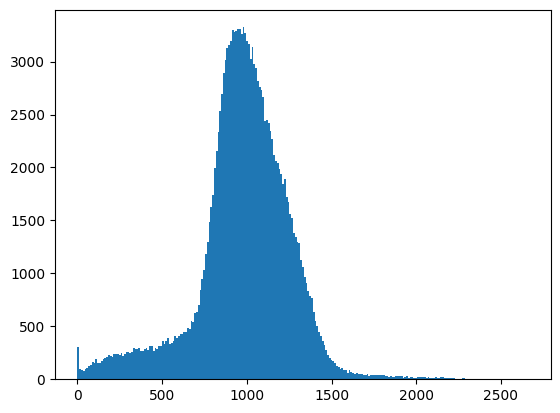

In [28]:
plt.hist(np.mean(tr, 0), bins='auto');

In [70]:
tr_sum

array([ 41.80129 ,  46.018612, 264.17856 , ..., 585.2009  , 192.39209 ,
       113.24883 ], dtype=float32)

In [51]:
tr[0] < gs[0]

89478

In [53]:
tr_sum > gs*0.4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [15]:
tr_sum.min()

0.0

In [16]:
tr_sum.max()

363805.9

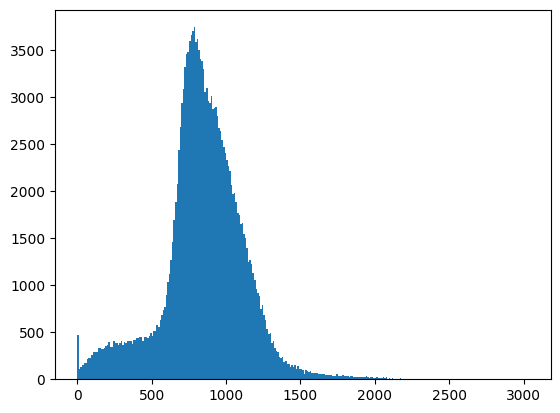

In [19]:
plt.hist(tr_sum, bins='auto');

In [72]:
from nilearn.maskers import NiftiLabelsMasker, NiftiMasker

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(labels_img=atlas.atlas_path,
                         #labels=l,
                         mask_img='/home/tm/projects/OpenCloseProject/notebooks/sub-002_run-1_new_mask_0.7.nii.gz',
                         memory="nilearn_cache",
                         verbose=1,
                         standardize='False',
                         detrend=True,
                         #resampling_target='labels'
                         )

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
#masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
#report = masker.generate_report()
#report

In [55]:
import nibabel as nib
filename = r'C:\Users\user\Desktop\open_close_001\derivatives\sub-001\func\swau001_CLOSE.nii'
img = nib.load(filename)
img.shape
# (512, 512, 539)

(91, 109, 91, 120)

In [74]:
masker.fit(img_pth)

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

[NiftiLabelsMasker.fit] loading data from ../atlas/HCPex.nii.gz
[NiftiLabelsMasker.fit] loading data from /home/tm/projects/OpenCloseProject/notebooks/sub-002_run-1_new_mask_0.7.nii.gz


DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [41]:
from nilearn import image

atlas = image.load_img('../atlas/HCPex.nii.gz')
atlas_values = set(image.get_data(atlas).astype(int).ravel())
print(
    f"atlas contains {len(atlas_values)} "
    "non-empty regions (including background = 0)"
)
print(
    "empty regions:",
    set(range(max(atlas_values) + 1)).difference(atlas_values),
)

atlas contains 427 non-empty regions (including background = 0)
empty regions: set()


# 

In [12]:
import os

import numpy as np
import pandas as pd
from nilearn.interfaces.fmriprep import load_confounds
from tqdm.notebook import tqdm


class Denoising:
    r""" 
    Confound regression using fmriprep output

    Attributes
    ----------
    strategy: denoising strategy to be used

    Methods
    -------
    denoise(sub)
        Performs denoising 

    fetch outputs(sub)
        Returns preprocessed time-series
    """

    def __init__(self, dataset, atlas,
                 strategy, n_compcor=None,
                 use_GSR=False, use_cosine=True,
                 smoothing=None):
        r"""
        Parameters
        ----------
        dataset: Dataset
            Dataset instance to denoise
        atlas: Atlas
            Atlas instance to be used
        strategy: int
            Strategy number:

            1. 24 parameters

            2. aCompCor + 12P

            3. aCompCor50 + 12P

            4. aCompCor + 24P

            5. aCompCor50 + 24P

        n_compcor: int, optional
            Number of principal components to be used in compcor in strategy 2 and 4 (10 by default)
        use_GSR: bool, optional
            Whether to use Global signal regressors. If True, 4 parameters are used (False by default)
        use_cosine: bool
            Whether to use cosine transforms. If False, bandpass filter (0.008 Hz and 0.09 Hz) is used (True by default)
        smoothing: float, optional
            If not None, smoothing with passed kernel is applied (None by default)
        """

        self.dataset = dataset
        self.atlas = atlas
        self.masker = atlas.masker

        self.int_strategy = strategy
        self.use_cosine = use_cosine
        self.use_GSR = use_GSR
        self.smoothing = smoothing
        self.n_compcor = 10 if n_compcor is None else n_compcor

    @property
    def strategy(self):
        # 24P
        strategy_1 = {'strategy': ['motion'],
                      'motion': 'full',
                      }
        # compcor, 12p
        strategy_2 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'derivatives',
                      'compcor': 'anat_combined',
                      'n_compcor': self.n_compcor}
        # compcor50, 12p
        strategy_3 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'derivatives',
                      'compcor': 'anat_combined',
                      'n_compcor': 'all'}
        # compcor, 24p
        strategy_4 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': self.n_compcor}
        # compcor50, 24p
        strategy_5 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': 'all'}

        strategy_6 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'temporal_anat_combined',
                      'n_compcor': 'all'}

        strategy = [strategy_1, strategy_2, strategy_3,
                    strategy_4, strategy_5, strategy_6][self.int_strategy-1]

        if self.use_GSR:
            strategy['strategy'].append('global_signal')
            strategy['global_signal'] = 'full'  # 4p

        if self.use_cosine is False:
            self.masker.set_params(high_pass=0.008,
                                   low_pass=0.09,
                                   t_r=self.dataset.t_r)

        if self.smoothing is not None:
            self.masker.set_params(smoothing_fwhm=self.smoothing)

        return strategy

    def denoise(self, sub=None, save_outputs=True, folder=None):
        """ 
        Denoising process

        Parameters
        ----------
        sub: list of str, optional
            List of subject labels to process if provided. Otherwise all subjects in the datased are processed (None by default)
        
        save_outputs: bool, optional
            whether to save outputs as csv files (True by default)
        
        folder: str or None, optional
            path to folder (otherwise outputs will be saved in derivatives path)

        Returns
        -------
        list of lists of np.arrays
            For every subject, for every run denoised time series (np.array of shape (n_timepoints, n_roi))
        
        """

        # use all the subjects defined in dataset
        if sub is None:
            sub = self.dataset.sub_labels

        denoised = []
        failed_subs = []

        for s in tqdm(sub):
            #try:
                denoised.append(
                    self._denoise_one_sub(sub=s, save_outputs=save_outputs, folder=folder))
            #except ValueError:
                #failed_subs.append(s)
                #continue
            #except IndexError:
                #failed_subs.append(s)
                #continue

        if failed_subs:
            print(f'failed to process: {failed_subs}')

        return denoised

    def _denoise_one_sub(self, sub, save_outputs, folder):
        """
        Process and save one subject

        Parameters
        ----------
        sub: str
            Subject label
        
        Returns
        -------
        list
            List of len runs with time series (np.array) 
        """

        imgs = self.dataset.get_func_files(sub=sub)
        #masks = self.dataset.get_mask_files(sub=sub)
        #mask = 
        #print(len(masks), 'mask')
        #assert len(imgs) == self.dataset.runs, "All runs should be in one folder"

        confounds, _ = load_confounds(imgs, **self.strategy)
        denoised_ts = []

        #runs = self.dataset.runs
        #sessions = 1 if self.dataset.sessions is None else self.dataset.sessions
        
        for i in range(len(imgs)):

            if self.use_cosine is False:
                # delete cosines from confounds df if we use bandpass filter
                confounds[i].loc[:, ~confounds[i].columns.str.startswith('cosine')]
            #print(i)
            
            #self.masker.set_params(mask_img=masks[i])
            d = self.masker.fit_transform(imgs[i], confounds=confounds[i])

            # for one subject d.shape is (1, :, :)
            d = np.squeeze(d)

            denoised_ts.append(d)

            if save_outputs: # fix run and session in name
                _ = self._save_outputs(d, sub, run=i, folder=folder)

        return denoised_ts#, d

    def _save_outputs(self, outputs, sub, run, folder=None):
        """
        Saves processed time-series as csv files for every run

        Parameters
        ----------
        outputs: np.array
            Array with time-series
        sub: str
            Subject label without 'sub'
        run: int
            Run int

        Returns
        -------
        pd.DataFrame
            DataFrame where column names are roi labels
        """
        if folder is None:
            folder = self.dataset.derivatives

        path_to_save = os.path.join(folder, f'sub-{sub}',
                                    'time-series', self.atlas.atlas_name)
        
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)

        # TODO добавить в название файла GSR и smoothing
        name = f'sub-{sub}_task-{self.dataset.task}_run-{run+1}_time-series_{self.atlas.atlas_name}_strategy-{self.int_strategy}.csv'

        df = pd.DataFrame(outputs)
        df.to_csv(os.path.join(path_to_save, name), index=False)

        return df

    def fetch_timeseries(self, run, sub=None):
        # TODO
        """
        Fetch processed time-series one run

        Parameters
        ----------
        run: int
            Run number
        sub: list of str, optional
            Subject labels to fetch data from

        Returns
        -------
        list of np.arrays

        """

        if sub is None:
            sub = self.dataset.sub_labels

        ts = []
        for i in sub:
            name = f'sub-{i}_task-{self.dataset.task}_run-{run}_time-series_{self.atlas.atlas_name}_strategy-{self.int_strategy}.csv'
            path = os.path.join(
                self.dataset.derivatives, f'sub-{i}', 'time-series', self.atlas.atlas_name, name)
            ts.append(pd.read_csv(path).values)

        return ts


In [19]:
denoise = Denoising(data, atlas, 
                    # enter denoising options here
                    strategy=4, 
                    use_GSR=False, 
                    use_cosine=True, 
                    smoothing=None) 


Denoised time-series are saved as csv files in derivatives directory in time-series folder for every subject. 
Filename contains chosen atlas and strategy number. 

![Alt text](image.png)

In [ ]:
# don't pass any arguments to process all subjects in the directory
ts = denoise.denoise(save_outputs=True, folder='TRT_outputs')

failed to process: ['33259', '58949', '86146']

In [28]:
data.sub_labels[9]

'34482'

In [21]:
# or pass subjects' labels you need 

sub_labels = [
    #'27641',
    data.sub_labels[10],
    data.sub_labels[0]
]

ts = denoise.denoise(sub_labels, save_outputs=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
#parcel_coverage = np.load('/home/tm/projects/OpenCloseProject/notebooks/parcel_coverage_ihb_03.npy')
parcel_coverage = np.delete(parcel_coverage, [401, 372, 405])

In [23]:
ts2 = ts[0][0][:, parcel_coverage>0.5]

{401.0, 365.0, 398.0}

{396.0, 365.0, 401.0, 372.0, 405.0}

{401.0, 372.0, 405.0}


In [ ]:
closed = denoise.fetch_timeseries(run=1)

In [12]:
opened = denoise.fetch_timeseries(run=2)

In [18]:
def fetch_ts(path, sub=None, run=1, task='rest', strategy=4, atlas_name='AAL'):
    ts = []
    if sub is None:
        sub = os.listdir(path)
    failed = []
    for i in sub:
        if not isinstance(i, str):
            i = str(i)
        if 'sub' in i:
            i = i[4:]
        try:
            name = f'sub-{i}_task-{task}_run-{run}_time-series_{atlas_name}_strategy-{strategy}.csv'
            path_to_file = os.path.join(path, f'sub-{i}', 'time-series', atlas_name, name)
            #print(path_to_file)
            ts.append(pd.read_csv(path_to_file).values)
        except FileNotFoundError:
            failed.append(i)
            continue
    print('no files available:', failed)
    return ts

In [44]:
closed = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs',
                  #sub=['001'], m 
                  run=1, atlas_name='AAL', strategy=4)
#/home/tm/projects/OpenCloseProject/notebooks/outputs/sub-001/time-series/HCPex/sub-001_task-rest_run-1_time-series_HCPex_strategy-6.csv

no files available: []


In [26]:
closed = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  #sub=['001'], 
                  run=1, atlas_name='AAL', strategy=4)

no files available: []


In [86]:
del opened[24]

In [87]:
np.save('/home/tm/projects/OpenCloseProject/files/china_close_roi_Brainnetome.npy', closed)
np.save('/home/tm/projects/OpenCloseProject/files/china_open_roi_Brainnetome.npy', opened)

In [24]:
trt1 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=1, atlas_name='HCPex', strategy=4)
trt2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=2, atlas_name='Schaefer200', strategy=6)
trt3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/TRT_outputs',
               #sub=,
               run=3, atlas_name='Schaefer200', strategy=6)

no files available: []
no files available: []
no files available: []


In [17]:
np.save('/home/tm/projects/OpenCloseProject/files/trt_roi_HCPex_ses-1.npy', trt1)
np.save('/home/tm/projects/OpenCloseProject/files/trt_roi_HCPex_ses-2.npy', trt2)
np.save('/home/tm/projects/OpenCloseProject/files/trt_roi_HCPex_ses-3.npy', trt3)

### mean ts by network

In [6]:
data.sub_labels[24]

'94293'

In [6]:
import pandas as pd
df = pd.read_csv(r"C:\Users\ТМ\Desktop\BeijingEOEC.csv")

open_ids2 = df['SubjectID'].loc[df['Session_2'] == 'open'].values
open_ids3 = df['SubjectID'].loc[df['Session_3'] == 'open'].values

closed_ids2 = df['SubjectID'].loc[df['Session_2'] == 'closed'].values
closed_ids3 = df['SubjectID'].loc[df['Session_3'] == 'closed'].values

In [8]:
closed1 = np.load(r'C:\Users\ТМ\YandexDisk\IHB\Projects\OpenCloseFMRI\data\open_close_time-series\networks\china_close_mean_ts_by_network_HCPex.npy')

In [ ]:
closed1[:, :48, :]

In [143]:
closed1 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  #sub=['001'], 
                  run=1, atlas_name='Brainnetome', strategy=6)

closed2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=closed_ids2, 
                  run=2, atlas_name='Brainnetome', strategy=6)

closed3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=closed_ids3, 
                  run=3, atlas_name='Brainnetome', strategy=6)

closed = closed1 + closed2 + closed3

no files available: []
no files available: []
no files available: []


In [144]:
for i in range(len(closed)):
    if len(closed[i]) < 240:
        print(i)

84


In [145]:
del closed[84]

In [7]:
len(open_ids2) + len(open_ids3)

48

In [146]:
opened2 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=open_ids2, 
                  run=2, atlas_name='Brainnetome', strategy=6)
opened3 = fetch_ts('/home/tm/projects/OpenCloseProject/notebooks/outputs_china',
                  sub=open_ids3, 
                  run=3, atlas_name='Brainnetome', strategy=6)

opened = opened2 + opened3
for i in range(len(opened)):
    if len(opened[i]) < 240:
        print(i)

no files available: []
no files available: []
22


In [177]:
47+95

142

In [175]:
len(closed1)

48

In [174]:
len(closed)

95

In [172]:
opened[0].shape

(240, 246)

In [147]:
del opened[22]

#### hcp

In [105]:
import pandas as pd
hcp = pd.read_excel('/home/tm/projects/OpenCloseProject/atlas/HCPex_sorted.xlsx', index_col='HCPex_ID')

In [106]:
hcp.sort_index(inplace=True)

In [105]:
hcp = hcp.drop([401, 365, 398], axis=0)

In [107]:
hcp = hcp.drop([396, 365, 401, 372, 405], axis=0)

In [20]:
#401.0, 372.0, 405.0
hcp = hcp.drop([401, 372, 405], axis=0)

In [108]:
for i in closed:
    i.columns = hcp.index

In [109]:
for i in opened:
    i.columns = hcp.index

In [111]:
len(closed)

95

In [112]:
closed[0].shape

(240, 421)

In [113]:

def mean_ts(ts, net):
    l = np.zeros((len(ts), len(ts[0])))
    for i in range(len(ts)):
        l[i] = np.mean(ts[i][hcp.loc[hcp.ColeAnticevic_network == net].index], axis=1)
        
    return l

In [114]:
unq = hcp.ColeAnticevic_network.unique()
all_net_cl = np.zeros((len(unq), len(closed), len(closed[0])))

for net in range(1, 15):
    all_net_cl[net-1] = mean_ts(closed, net)

In [115]:
all_net_op = np.zeros((len(unq), len(opened), len(opened[0])))

for net in range(1, 15):
    all_net_op[net-1] = mean_ts(opened, net)

In [116]:
all_net_cl.shape

(14, 95, 240)

In [117]:
np.save('/home/tm/projects/OpenCloseProject/files/china_close_mean_ts_by_network_HCPex.npy', all_net_cl)

In [118]:
np.save('/home/tm/projects/OpenCloseProject/files/china_open_mean_ts_by_network_HCPex.npy', all_net_op)

In [115]:
hcp.ColeAnticevic_network_label.unique()

array(['Visual1', 'Visual2', 'Somatomotor', 'Cingulo-Opercular',
       'Language', 'Dorsal-Attention', 'Auditory', 'Default',
       'Orbito-Affective', 'Frontoparietal', 'Ventral-Multimodal',
       'Posterior-Multimodal', 'Thalamus', 'Subcortical'], dtype=object)

In [118]:
np.savetxt('../network_names.txt', hcp.ColeAnticevic_network_label.unique(), fmt='%s')

#### schaefer

In [43]:
atlas.atlas_path

'../atlas/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'

In [44]:
nets = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

In [48]:
nets_d = {}
for v in nets:
    vl = []
    for k in trt1[0].columns:
        if v in k:
            vl.append(k)

    nets_d[v] = vl


In [ ]:
nets_d

In [93]:
del opened[24]

In [119]:
def sch_net(trt1):
    op_mean = np.zeros((7, len(trt1), len(trt1[0])))

    for net in range(7):
        nname = nets[net]
        for sub in range(len(trt1)):
            op_mean[net, sub] = np.mean(trt1[sub][nets_d[nname]].values, axis=1)
    return op_mean

In [128]:
op_mean = sch_net(closed)

In [129]:
np.save('/home/tm/projects/OpenCloseProject/files/china_close_mean_ts_by_network_Schaefer200.npy', op_mean)

In [123]:
cl_mean = np.zeros((7, 84, 120))

for net in range(7):
    nname = nets[net]
    for sub in range(84):
        cl_mean[net, sub] = np.mean(closed[sub][nets_d[nname]].values, axis=1)

In [124]:
np.save('../ihb_open_mean_ts_by_network_Schaefer200.npy', op_mean)

In [125]:
np.save('../ihb_close_mean_ts_by_network_Schaefer200.npy', cl_mean)

#### brainnetome

In [131]:
bntm = pd.read_csv('/home/tm/projects/OpenCloseProject/atlas/subregion_func_network_Yeo_updated.csv')

In [134]:
bntm.head(20)

,Label,subregion_name,region,Yeo_7network,Yeo_17network,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1,A8m,SFG_L_7_1,6,17,NaN,NaN,NaN,NaN,NaN,Yeo 7 Network,NaN
1,2,A8m,SFG_R_7_1,4,8,NaN,NaN,NaN,NaN,NaN,ID,Network name
2,3,A8dl,SFG_L_7_2,7,16,NaN,NaN,NaN,NaN,NaN,1,Visual
3,4,A8dl,SFG_R_7_2,6,13,NaN,NaN,NaN,NaN,NaN,2,Somatomotor
4,5,A9l,SFG_L_7_3,7,17,NaN,NaN,NaN,NaN,NaN,3,Dorsal Attention
5,6,A9l,SFG_R_7_3,7,17,NaN,NaN,NaN,NaN,NaN,4,Ventral Attention
6,7,A6dl,SFG_L_7_4,3,6,NaN,NaN,NaN,NaN,NaN,5,Limbic
7,8,A6dl,SFG_R_7_4,3,6,NaN,NaN,NaN,NaN,NaN,6,Frontoparietal
8,9,A6m,SFG_L_7_5,2,3,NaN,NaN,NaN,NaN,NaN,7,Default
9,10,A6m,SFG_R_7_5,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
len(bntm)

246

In [155]:
bntm.columns

Index(['Label', 'subregion_name', 'region', 'Yeo_7network', 'Yeo_17network',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [156]:
cols = ['subregion_name', 'Yeo_7network']

In [139]:
bntm[['Unnamed: 10', 'Unnamed: 11']].iloc[2:9]

,Unnamed: 10,Unnamed: 11
2,1,Visual
3,2,Somatomotor
4,3,Dorsal Attention
5,4,Ventral Attention
6,5,Limbic
7,6,Frontoparietal
8,7,Default


In [140]:
ntw = {i+1: k for i, k in enumerate(bntm['Unnamed: 11'].iloc[2:9].values)}

In [151]:
nets = bntm['Unnamed: 11'].iloc[2:9].values

In [167]:
cc = bntm['region'].loc[bntm[cols[1]] == 1].values

In [168]:
cc

array(['FuG_L_3_2', 'FuG_R_3_2', 'FuG_R_3_3', 'PhG_R_6_2', 'PhG_L_6_3',
       'PhG_R_6_3', 'PhG_L_6_6', 'PhG_R_6_6', 'IPL_L_6_1', 'IPL_R_6_1',
       'PCun_L_4_3', 'PCun_R_4_3', 'CG_R_7_4', 'MVOcC_L_5_1',
       'MVOcC_R_5_1', 'MVOcC_L_5_2', 'MVOcC_R_5_2', 'MVOcC_L_5_3',
       'MVOcC_R_5_3', 'MVOcC_L_5_4', 'MVOcC_R_5_4', 'MVOcC_L_5_5',
       'MVOcC_R_5_5', 'LOcC_L_4_1', 'LOcC_R_4_1', 'LOcC_R_4_2',
       'LOcC_L_4_3', 'LOcC_R_4_3', 'LOcC_L_4_4', 'LOcC_R_4_4',
       'LOcC_L_2_1', 'LOcC_R_2_1', 'LOcC_L_2_2', 'LOcC_R_2_2'],
      dtype=object)

In [170]:
opened[0].columns

Index(['A8m_L', 'A8m_R', 'A8dl_L', 'A8dl_R', 'A9l_L', 'A9l_R', 'A6dl_L',
       'A6dl_R', 'A6m_L', 'A6m_R',
       ...
       'rTtha_L', 'rTtha_R', 'PPtha_L', 'PPtha_R', 'Otha_L', 'Otha_R',
       'cTtha_L', 'cTtha_R', 'lPFtha_L', 'lPFtha_R'],
      dtype='object', length=246)

In [153]:
def sch_net(trt1, nets_d):
    op_mean = np.zeros((7, len(trt1), len(trt1[0])))

    for net in range(7):
        nname = nets[net]
        for sub in range(len(trt1)):
            op_mean[net, sub] = np.mean(trt1[sub][nets_d[nname]].values, axis=1)
    return op_mean

In [154]:
sch_net(opened, ntw)

KeyError: 'Visual'

### Compute functional connectivity

In [13]:
trt1[1].shape

(197, 423)

In [25]:
trt_fc = functional_connectivity(trt1, 'correlation')

In [26]:
ts2.shape

(197, 407)

In [27]:
fc_cl = functional_connectivity(ts2, 'correlation')
#reor_cl = reorder_matrix(fc_cl, 'HCPex')
#fc_op = functional_connectivity(opened, 'correlation')
#reor_op = reorder_matrix(fc_op, 'HCPex')

In [27]:
fc_cl_old = functional_connectivity(closed, 'correlation')

In [30]:
fc_cl_old = trt_fc

In [95]:
fc_cl.shape

(407, 407)

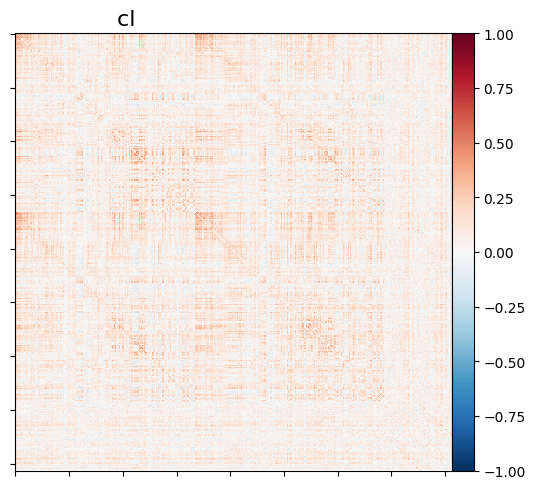

In [28]:
from nilearn import plotting
plotting.plot_matrix(
    fc_cl,
    labels=None,
    vmax=1,#np.max(fc6[0]),
    vmin=-1,#-np.max(fc6[0]),
    title="cl                              ",
    reorder=False)


In [29]:
fc_cl.shape

(114, 114)

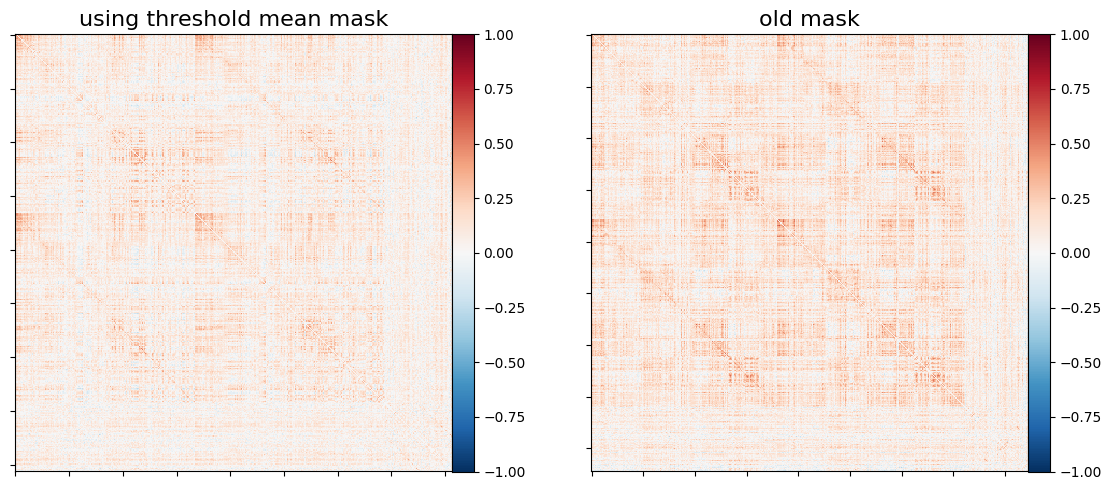

In [31]:
from nilearn import plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plotting.plot_matrix(
    fc_cl,
    labels=None,
    vmax=1,#np.max(fc6[0]),
    vmin=-1,#-np.max(fc6[0]),
    title="using threshold mean mask",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    fc_cl_old[10],
    labels=None,
    vmax=1,#np.max(fc5[0]),
    vmin=-1,#-np.max(fc5[0]),
    title="old mask",
    reorder=False, axes=ax2)

In [38]:
np.corrcoef(fc_cl.flatten(), fc_cl_old[0].flatten())

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10404 and the array at index 1 has size 13456

In [89]:
np.corrcoef(fc_cl[0][2].flatten(), fc_cl[1][2].flatten())

array([[1.        , 0.15712201],
       [0.15712201, 1.        ]])

In [78]:
np.corrcoef(fc_cl[0][2].flatten(), fc_cl[0][0].flatten())

array([[1.        , 0.43801397],
       [0.43801397, 1.        ]])